# Inverted Pendulum

Author: Michael Greer

This notebook provides an implementation of a rotational inverted pendulum (or Furuta pendulum). This contains the physics required to simulate the system, as well as derivation of a state-feedback controller to stabilize the system about it's upright position.

In [2]:
import numpy as np
import sympy as sp
from scipy import signal

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import math
from math import cos, sin, pi

import time

### Kinematic Structure

First, we need a kinematic structure for our pendulum. To derive this, we use Denavit-Hartenberg parameters. The DH Table is shown below:

| link | d | theta | a | alpha |
|------|---|-------|---|-------|
| 1    | 0 | q1    | 0 | -pi/2 |
| 2    | 0 | q2    | 0 | 0     |

Where q1 and q2 are the angles of the first and second joint. This turns out to be one of the weird cases you get with DH parameters where the two joints are actually co-located, but it does not make any difference kinematically.

It's helpful to graph the robot pose to check your work, and the functions below do exactly that. Check several poses by changing the values in the q array.

In [20]:
# Constants

l1 = 0.1
l2 = 0.1

m1 = 0.2
m2 = 0.2

In [21]:
# Function for plotting the system
def lines(q):
    
    T0_2 = T0_1(q) @ T1_2(q)
    
    points = np.zeros((4,3))
    
    points[:,0] = np.array([0, 0, 0, 1]).T
    
    points[:,1] = T0_2 @ np.array([0, 0, l1, 1]).T
    
    points[:,2] = T0_2 @ np.array([0, l2, l1, 1]).T
    
    return points 
  
    
# Functions to generate transformation matrices
def T0_1(q):
    
    q1, q2 = q[0], q[1]
    
    trans = np.zeros((4,4))
    
    trans[0,:] = np.array([cos(q1), 0, -1*sin(q1), 0])
    trans[1,:] = np.array([sin(q1), 0, cos(q1), 0])
    trans[2,:] = np.array([0, -1, 0, 0])
    trans[3,:] = np.array([0, 0, 0, 1])
    
    return trans

    
def T1_2(q):
    
    q1, q2 = q[0], q[1]
    
    trans = np.zeros((4,4))
    
    trans[0,:] = np.array([cos(q2), -1*sin(q2), 0, 0])
    trans[1,:] = np.array([sin(q2), cos(q2), 0, 0])
    trans[2,:] = np.array([0, 0, 1, 0])
    trans[3,:] = np.array([0, 0, 0, 1])
    
    return trans

[[ 0.000000e+00 -1.000000e-01 -1.000000e-01]
 [ 0.000000e+00  6.123234e-18  6.123234e-18]
 [ 0.000000e+00  0.000000e+00 -1.000000e-01]
 [ 1.000000e+00  1.000000e+00  1.000000e+00]]


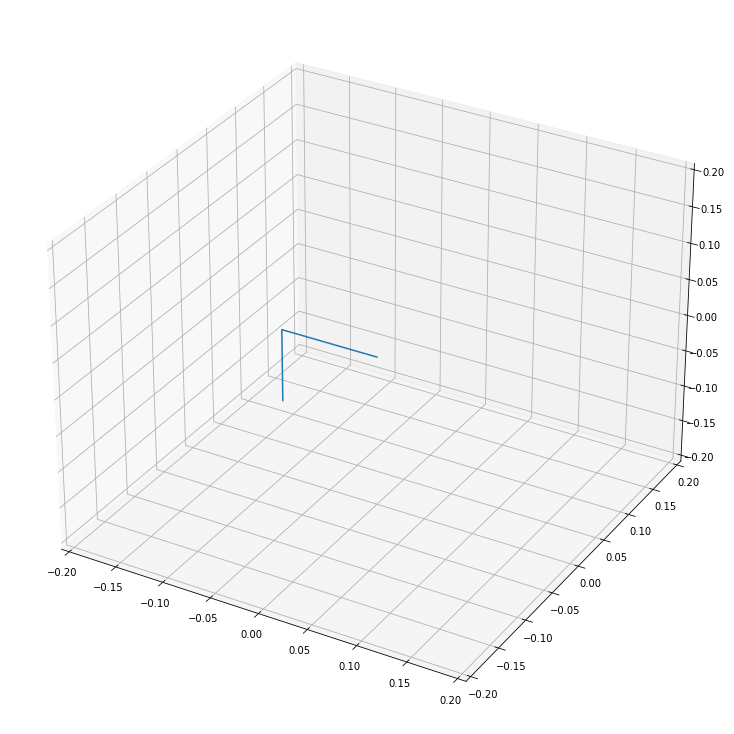

In [23]:
q = np.array([pi/2, 0])

fig = plt.figure(figsize = (10,10))
ax = Axes3D(fig)

ax.axes.set_xlim3d(-0.2, 0.2) 
ax.axes.set_ylim3d(-0.2, 0.2) 
ax.axes.set_zlim3d(-0.2, 0.2) 

drawing = None;

simlen = 100

#prev_states = np.zeros(3,simlen)

plot_points = lines(q)

print(plot_points)
    
ax.plot(plot_points[0,:],plot_points[1,:],plot_points[2,:])   

plt.show()

### Dynamics

Now that we have the kinematics figured out, we move on to deriving the dynamics. For this, I use the classical formulation of the mass, coriolis, and gravity matrices shown in any robotics textbook. This can be found in chapter 8 of the free *Modern Robotics* by Lynch and Park. The formulation is as follows:

$$\tau=D(q)\ddot{q}+C(q,\dot{q})\dot{q}+g(q)$$

Where $\tau$ is the generalized force, or **wrench** applied at each joint. This approach is derived from Lagrangian Dynamics, which relies on the exchange of energy in the system between kinetic and potential energy. I'm not going to go in depth into this here, but I may make another notebook that is specifically about these dynamics. Let me know if you're interested!

First, we define the symbols that will be necessary to calculate each of these matrices.

In [25]:
# Sympy code to help get dynamics

m1, l1 = sp.symbols('m1 l1')
m2, l2 = sp.symbols('m2 l2')

q1, q2 = sp.symbols('q1 q2')
q1_dot, q2_dot = sp.symbols('q1_dot q2_dot')

g_con = sp.symbols('g_con')

Since the coriolis matrix is derived from the mass matrix, it makes sense to do the mass matrix first. For this, we need to find the jacobian matrix at the center of mass for each of the joints. This is performed by formulating the transformation matrices for each joint, then using the link lengths to locate the center of mass in space. Then we differentiate the center of mass equation by each of the joint variables, which forms the linear portion of the jacobian. The rotational portion of the jacobian is simple equal to the axis of rotation of each joint.

In [26]:
# Transformations
T0_1 = sp.Matrix([[sp.cos(q1), 0, -1*sp.sin(q1), 0],
                  [sp.sin(q1), 0, sp.cos(q1), 0],
                  [0, -1, 0, 0],
                  [0, 0, 0, 1]])


T1_2 = sp.Matrix([[sp.cos(q2), -1*sp.sin(q2), 0, 0],
                  [sp.sin(q2), sp.cos(q2), 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])

# Center of mass vectors
rc1 = T0_1 @ sp.Matrix([[0],[0],[l1/2],[1]])

rc2 = (T0_1 @ T1_2) @ sp.Matrix([[0],[l2/2],[l1],[1]])


rc1.row_del(3)

rc2.row_del(3)

# Linear jacobian
Jv1 = sp.diff(rc1, q1).row_join(sp.diff(rc1, q2))

Jv2 = sp.diff(rc2, q1).row_join(sp.diff(rc2, q2))

# Angular jacobian
Jw1 = sp.Matrix([[0 , 0],[0 , 0],[1 , 0]])

Jw2 = sp.Matrix([[0 , -1*sp.sin(q1)],[0 , sp.cos(q1)],[1 , 0]])

I chose to model the sections of the pendulum as infinitely narrow rods. This is a good enough approximation, although there are other ways to get more precise. Note that for the second link, the rod is alinged with the y-axis instead of the z-axis.

The inertia tensor should always be about the center of mass, since we model the linear and rotational motion independently.

In [27]:
R1 = T0_1[0:3,0:3]

R2 = (T0_1 * T1_2)[0:3,0:3]

i1 = m1 * l1**2 / 12
i2 = m2 * l2**2 / 12

Ic1 = sp.Matrix([[i1 , 0 , 0],
                 [0 , i1 , 0],
                 [0 , 0 , 0]])

Ic2 = sp.Matrix([[i2 , 0 , 0], # This one is along the y axis
                 [0 , 0 , 0],
                 [0 , 0 , i2]])

Now, we plug all of these terms into the final formulation of the mass matrix, shown below.

In [29]:
D = m1*Jv1.T*Jv1 + m2*Jv2.T*Jv2 + Jw1.T*R1*Ic1*R1.T*Jw1 + Jw2.T*R2*Ic2*R2.T*Jw2

D = sp.simplify(D)

D

Matrix([
[l1**2*m1/3 + l1**2*m2 + l2**2*m2*sin(q2)**2/3, l1*l2*m2*cos(q2)/2],
[                           l1*l2*m2*cos(q2)/2,         l2**2*m2/3]])

Note that the D matrix is symmetrical. This should always be true for the mass matrix, so it's a good way to check your work.

Next, we find the gravitational matrix g. This is the part of the equation that deals with gravitational forces. We find the total potential energy of the system, then differentiate with respect to each of the joints.

In [31]:
# Find gravitational matrix g
grav = sp.Matrix([[0],[0],[g_con]])

P1 = m1 * grav.T * rc1
P2 = m2 * grav.T * rc2

P = P1 + P2

g = sp.diff(P, q1).col_join(sp.diff(P, q2))

g = sp.simplify(g)

g

Matrix([
[                    0],
[g_con*l2*m2*sin(q2)/2]])

This makes intuitive sense, because the first link will never be directly affected by the pull of gravity.

Next we find the coriolis matrix, which deals with forces caused by movement of the links. We use a tool called **Christoffel Symbols of the First Kind** to obtain the C matrix from the D matrix. Each symbol is obtained as follows:

$$c_{ijk}=\frac{1}{2}(\frac{\partial d_{kj}}{\partial q_{i}} + \frac{\partial d_{ki}}{\partial q_{j}} - \frac{\partial d_{ij}}{\partial q_{k}})$$

These symbols are then assembled into the C matrix using:

$$C_{kj}=\sum_{i=1}^{2} c_{ijk}\dot{q_{i}}$$

In [32]:
# Find rotational force matrix C

C = sp.zeros(2,2)

q = sp.Matrix([[q1],[q2]])
q_dot = sp.Matrix([[q1_dot],[q2_dot]])

for i in range(2):
    for j in range(2):
        for k in range(2):
            
            cijk = (1/2) * (sp.diff(D[k,j] , q[i]) + sp.diff(D[k,i] , q[j]) - sp.diff(D[i,j] , q[k])) * q_dot[i]
            
            C[k,j] = C[k,j] + cijk
            
D = sp.simplify(D)
g = sp.simplify(g)
C = sp.simplify(C)

print(D)
print()
print(C)
print()
print(g)

Matrix([[l1**2*m1/3 + l1**2*m2 + l2**2*m2*sin(q2)**2/3, l1*l2*m2*cos(q2)/2], [l1*l2*m2*cos(q2)/2, l2**2*m2/3]])

Matrix([[0.166666666666667*l2**2*m2*q2_dot*sin(2*q2), l2*m2*(-0.5*l1*q2_dot + 0.333333333333333*l2*q1_dot*cos(q2))*sin(q2)], [-0.166666666666667*l2**2*m2*q1_dot*sin(2*q2), 0]])

Matrix([[0], [g_con*l2*m2*sin(q2)/2]])


### Control

Now that we've derived these three matrices, we can implement these to form a nonlinear state-space equation and simulate them. But, how do we actually control the system? How do we apply torque to the first joint to balance the pendulum?

To accomplish this, we linearize the system at the point at which we'd like to stabilize the system. This gives us a linear approximation of the system at the point q=(0,0).

In [33]:
# Jacobian Linearization for state feedback control

# Torque symbols - remember we can only apply torque to the first joint
u1 = sp.symbols('u1')

u = sp.Matrix([[u1],[0]])

f = D.inv() * (u - C*q_dot - g)

f = q_dot.col_join(f)

A1 = sp.diff(f, q1)
A2 = sp.diff(f, q2)
A3 = sp.diff(f, q1_dot)
A4 = sp.diff(f, q2_dot)

A = A1.row_join(A2.row_join(A3.row_join(A4)))

#A = A.subs(q1, 0)
A = A.subs(q2, 0)
A = A.subs(q1_dot, 0)
A = A.subs(q2_dot, 0)
A = A.subs(u1, 0)

A = A.subs(l1, 0.1)
A = A.subs(l2, 0.1)
A = A.subs(m1, 0.2)
A = A.subs(m2, 0.2)

A = A.subs(g_con, -9.8)


B = sp.diff(f, u1)

B = B.subs(q1, 0)
B = B.subs(q2, 0)
B = B.subs(q1_dot, 0)
B = B.subs(q2_dot, 0)
B = B.subs(u1, 0)

B = B.subs(l1, 0.1)
B = B.subs(l2, 0.1)
B = B.subs(m1, 0.2)
B = B.subs(m2, 0.2)

B = B.subs(g_con, -9.8)

A = sp.simplify(A)

B = sp.simplify(B)

A, B

(Matrix([
 [0,      0, 1, 0],
 [0,      0, 0, 1],
 [0, -126.0, 0, 0],
 [0,  336.0, 0, 0]]),
 Matrix([
 [                0],
 [                0],
 [ 857.142857142857],
 [-1285.71428571429]]))

Here we have the A and B matrix approximation for our nonlinear system. We can check the local stability by printing out the eigenvalues of A, and we would find out (unsurprisingly) that the up position is an unstable equilibrium. Now, we can design a state-feedback controller using pole placement. 

In [11]:
# Finding values for K to stabilize the system
# Using Pole Placement 

A_np = np.array(A).astype(np.float64)
B_np = np.array(B).astype(np.float64)

P = np.array([-4, -5, -6, -7])

k = signal.place_poles(A_np, B_np, P).gain_matrix

k


array([[-0.00666667, -0.405     , -0.00506349, -0.02048677]])

### Simulation

Ok, now we're ready to tie it all together. The following functions will define each of the matrices to be solved during each time step, as well as the function to find the state derivatives.

In [40]:
# Constant initialization

l1 = 0.1
l2 = 0.1

m1 = 0.2
m2 = 0.2

In [79]:
# Convert these into methods that return numpy arrays

def D(q):
    
    q1, q2 = q[0], q[1]
    
    #print(q)
    
    D11 = (l1**2)*m1/3 + (l1**2)*m2 + (l2**2)*m2*(sin(q2)**2)/3
    D12 = l1*l2*m2*cos(q2)/2
    D21 = l1*l2*m2*cos(q2)/2
    D22 = (l2**2)*m2/3
    
    D_mat = np.array([[D11, D12],
                      [D21, D22]])
    
    return D_mat


def C(q, q_dot):
    
    q1, q2 = q[0], q[1]
    q1_dot, q2_dot = q_dot[0], q_dot[1]
    
    C11 = (l2**2*m2*q2_dot*sin(2*q2)/6)[0]
    C12 = (l2*m2*(-1*l1*q2_dot/2 + l2*q1_dot*cos(q2))*sin(q2)/3)[0]
    C21 = (-1*l2**2*m2*q1_dot*sin(2*q2)/6)[0]
    C22 = 0.0
        
    C_mat = np.array([[C11, C12],[C21,C22]])
        
    return C_mat


def g(q):
    
    q1, q2 = q[0], q[1]
    
    g_con = -9.8
    
    g_mat = np.array([[0], [g_con*l2*m2*sin(q2)/2]])
    
    return g_mat

In [80]:
# derivative function to feed into integrator

def dydt(y, t):
    
    q = y[0:2]
    q_dot = y[2:4]
    
    #ref = pi * sin(0.02 * t) # Sine Wave
    ref = 0.2 if sin(0.25 * t) > 0 else -0.2 # Square Wave
    #ref = ((t % 200) / 100) - 1  # Triangle Wave
    #ref = 0
    
    tau = torque(q, q_dot, ref)
    #tau = np.array([[0],[0]])
    
    fric = friction(q_dot)
    #fric = np.array([[0],[0]])
    
    #print(C(q, q_dot))
    #print(D(q))
    #print(np.linalg.inv(D(q)))
    #print(g(q))
    
    #print(tau)
    
    q_ddot = (np.linalg.inv(D(q))) @ (tau - C(q, q_dot)@q_dot - g(q) - fric)
    
    y_dot = np.zeros((4,1))
    
    y_dot[0:2] = q_dot
    y_dot[2:4] = q_ddot
    
    #print(q_ddot)
    
    #print()
    
    return y_dot

The torque function implements the linear feedback control we designed earlier, as well as a "swing up" function to get it into the right position.

In [81]:
def torque(q, q_dot, ref):
     
    # Stabilize
    if (abs(q[1]) < 0.3):
        
        err = np.array([q[0] - ref, q[1]])

        kp = np.array([[-0.00666667, -0.405]])
        kv = np.array([[-0.00506349, -0.02048677]])
    
        tau = kp @ err + kv @ q_dot
    
        tau = -1 * np.array([[tau[0][0]],[0.0]])
    
    # Swing up
    else:

        kp = 0
        kv = 0.0025
    
        tau = q[1]*kp + q_dot[1]*kv
    
        tau = np.array([[tau[0]],[0.0]])
    
    return tau

In [82]:
def friction(q_dot):
    
    return 0.0001 * q_dot

In [83]:
def plot_states(y):
    
    fig,a =  plt.subplots(2,2,figsize = (12,12))

    a[0][0].plot(y_trace[:,0])
    a[0][0].set_title('Position 1')
    
    a[0][1].plot(y_trace[:,1])
    a[0][1].set_title('Position 2')
    
    a[1][0].plot(y_trace[:,2])
    a[1][0].set_title('Velocity 1')
    
    a[1][1].plot(y_trace[:,3])
    a[1][1].set_title('Velocity 2')

    plt.show()

I am using the 4th-order runge-kutta ODE solving algorithm. It's more accurate than the typical Euler method.

In [84]:
from runge_kutta_step import *

# Initial conditions
y = np.array([[0] , [pi + 0.1] , [0] , [0]])

t = 0

h = 0.005

simtime = 50

y_trace = []

for i in range(int(simtime/h)):
    
    (y, t) = runge_kutta_step(dydt, y, t, h)
    
    if ((h*i) % (simtime/10) == 0):
        print("time: {}".format(h * i))
    
    y_trace.append(y)

y_trace = np.array(y_trace).reshape((-1,4))

print(y_trace.shape)

time: 0.0
time: 5.0
time: 10.0
time: 15.0
time: 20.0
time: 25.0
time: 30.0
time: 35.0
time: 40.0
time: 45.0
(10000, 4)


### Analysis

Now, we can analyze the graphs of each state to get an idea of how our controller performs. 

First, simulate with the torque set to zero so we can make sure the dynamics look correct. 

From there, simulate with the torque controller on and with the starting position relatively close to q=(0,0) to see how it can stabilize it.

Then, simulate with the arm in the down position.

Note that stability does not depend on the location of the first joint, so we can stablilize with the first joint at any angle. This is shows by changing the reference input to a square wave, sine wave, and sawtooth wave in the derivative function.

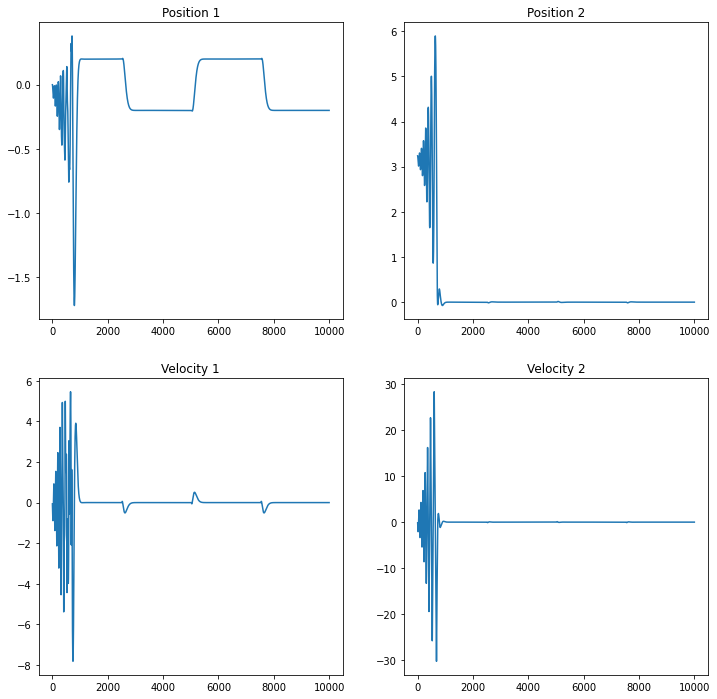

In [85]:
plot_states(y_trace)